In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
import pickle
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns



In [3]:
repo_dir = Path('../..')

In [4]:
if str(repo_dir) not in sys.path:
    sys.path.append(str(repo_dir))
    
from analysis.curve_fitting.src.fitting_functions import LOSS_FUNCTIONS
from analysis.curve_fitting.src.utils import apply_filters, load_yaml, convert_loss_parameters, convert_loss_parameters_batch, compute_scaling_law_coeffs

from visualization.src.utils import COLOR_PALETTES, set_ticks, COLORS, save_figs
from visualization.src.visualize import plot_reg, plot_reg_bivariate, plot_confidence_intervals



In [5]:
args = {
    'results_csv': repo_dir / 'results' / 'benchmark_scores_local.csv',
}

In [6]:
results_csv = args['results_csv']

df_results = pd.read_csv(results_csv)
df_results['total_flops'] = df_results['flops'] * df_results['n_samples_seen']

## Load Experiment Configuration

In [7]:
analysis_dir = repo_dir / 'analysis'
config_dir = analysis_dir / 'curve_fitting/configs/compute'
results_dir = analysis_dir / 'curve_fitting/fitting_results'

In [8]:
experiment_name = "chinchilla"
config = load_yaml(config_dir / f'{experiment_name}.yaml')


In [9]:
L_fit = config['fitting_parameters']['loss_function']
L_viz = config['visualization']['loss_function']
x1_scaler = float(config['fitting_parameters']['X1_scaler'])
x2_scaler = float(config['fitting_parameters']['X2_scaler'])



## Apply Data Filters

In [10]:
df = apply_filters(df_results, config.get('data_filters', {}))


## Load Fitting Results

In [11]:
with open(results_dir / f'compute_{experiment_name}' / 'results.pkl', 'rb') as f:
    results = pickle.load(f)


optimized_params = convert_loss_parameters(results['optimized_parameters'], L_fit, L_viz)

# Convert bootstrapped parameters
opt_params_boot = results['optimized_parameters_bootstrapped']
opt_params_boot = convert_loss_parameters_batch(
    params=opt_params_boot,
    src_loss=L_fit,
    dst_loss=L_viz
)

## Visualize

#### Plotting settings

In [12]:
multiplier = 1.0
X1_str = '\\tilde{N}'
X2_str = '\\tilde{D}'
linewidth = 3.0
alpha_scatter = 0.2
alpha_ci = 0.2
alpha_fit = 1.0
fig_multiplier = 0.7
figsize = (12, 8)
figsize = (fig_multiplier * figsize[0], fig_multiplier * figsize[1])


L = LOSS_FUNCTIONS[L_viz]
N = df.n_params.values / x1_scaler
D = df.n_samples_seen.values / x2_scaler
C = df.total_flops.values / (x1_scaler * x2_scaler)
scaling_coeff = compute_scaling_law_coeffs(optimized_params, (N, D, C))
scaling_coeff_boot = [
    compute_scaling_law_coeffs(opt_params, (N, D, C))
    for opt_params in opt_params_boot
]
x_scaler = x1_scaler * x2_scaler
compute = np.geomspace(5e13, 1e20, 1000)

color_palette = COLOR_PALETTES['samples']
color = COLORS['cyan_dark']

In [13]:
# color_palette = sns.color_palette(list(color_palette), as_cmap=True)

#### Plot

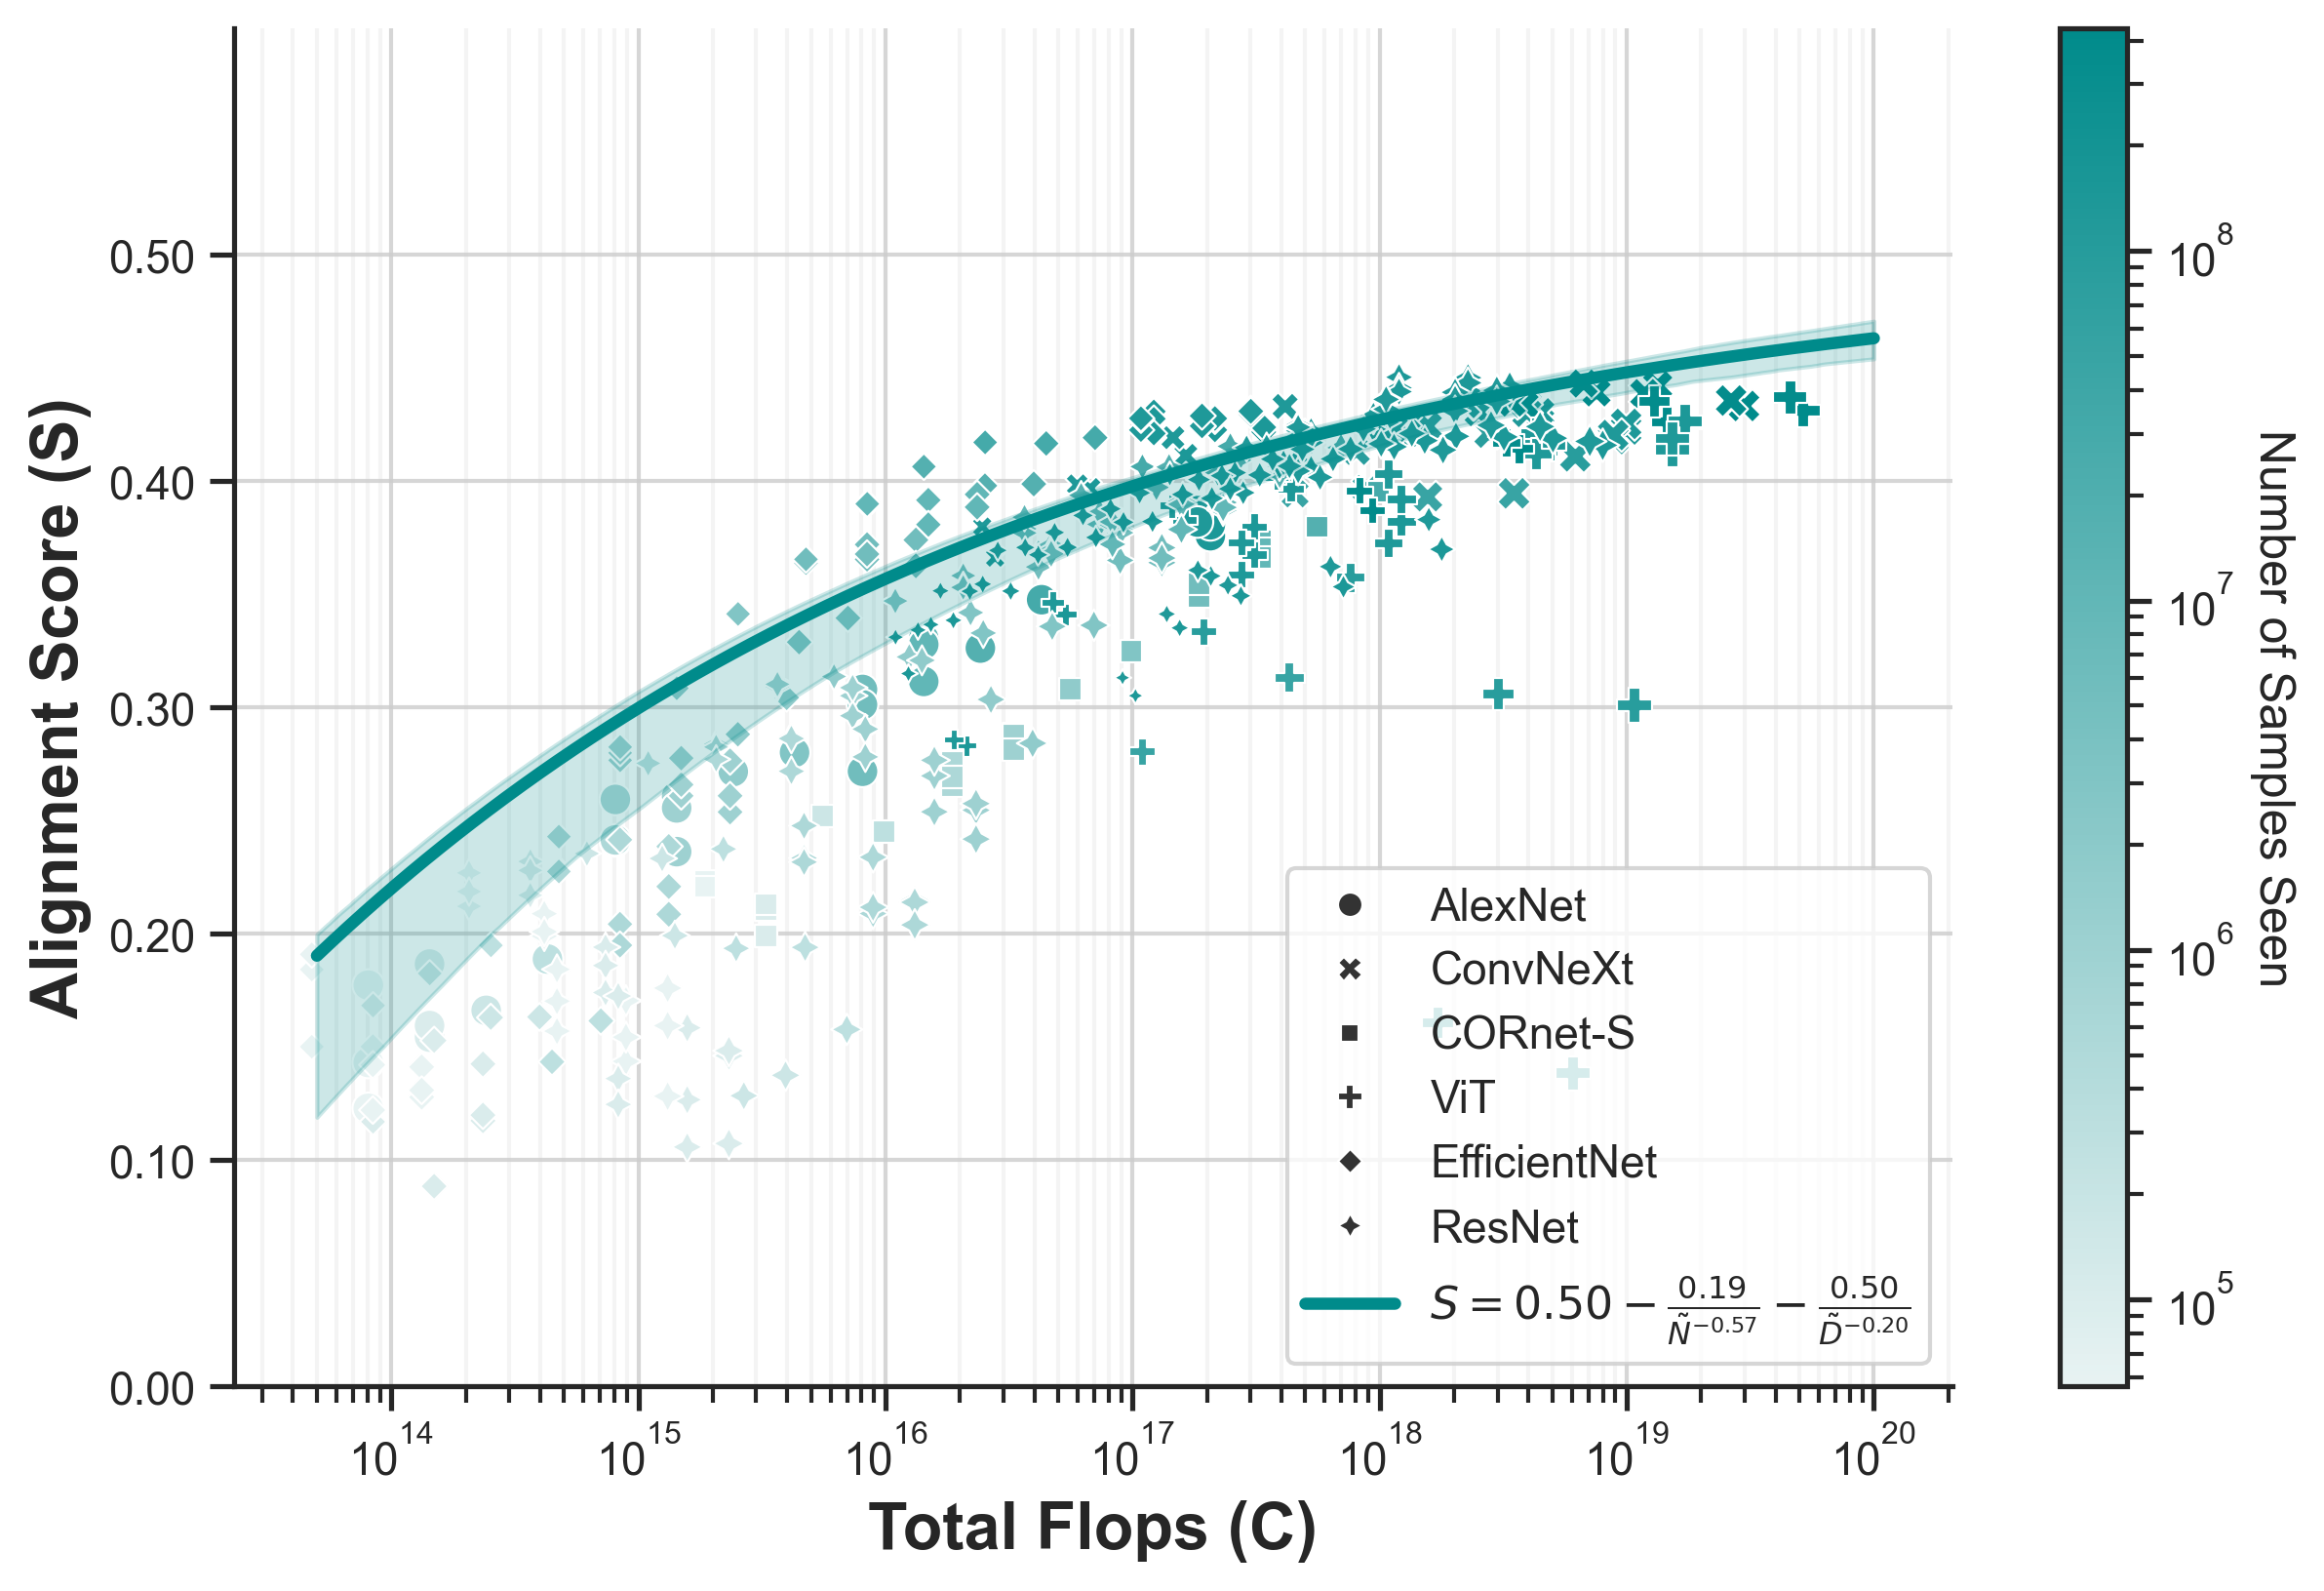

In [14]:
sns.set_theme(style='whitegrid')
sns.set_theme(style='ticks')


fig, axes = plt.subplots(1, 1, figsize=figsize, dpi=300)

ax = axes

### 
df_plot = df


sns.scatterplot(data=df_plot, x='total_flops', y='score', style='arch_family', size='n_params', hue='n_samples_seen', ax=ax, hue_norm=LogNorm(), size_norm=LogNorm(), palette=color_palette)


# plot_reg(X, optimized_params, L, ax, color=color, multiplier=multiplier, linestyle='-', X_str=X_str, x_scale_multiplier=x_scale_multiplier, show_x_scale_multiplier=False, linewidth=linewidth, legend=True)
plot_reg_bivariate(scaling_coeff, optimized_params, L, X_str=X1_str, Y_str=X2_str, ax=ax, color=color, x1_scale_multiplier=x1_scaler, x2_scale_multiplier=x2_scaler, linewidth=linewidth, alpha=alpha_fit)
plot_confidence_intervals(compute, opt_params_boot, L, ax, x_scaler=x_scaler, is_chinchilla=True, scaling_coeffs=scaling_coeff_boot, color=color, x_extend=multiplier, alpha=alpha_ci, percentile=95.0, invert_y=True)


### Colorbar
sm = plt.cm.ScalarMappable(cmap= color_palette, norm=LogNorm())
sm.set_clim(df_plot['n_samples_seen'].min(), df_plot['n_samples_seen'].max())
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Number of Samples Seen')
cbar.set_label('Number of Samples Seen', rotation=270, labelpad=15)


### Formatting
ax.set_xscale('log')
ax.set_ylim(0, 0.5)
ax.set_xlabel('FLOPs')
ax.set_ylabel('Alignment')
ax.set_xlabel('Total Flops (C)', fontsize=16, fontweight='bold')
ax.set_ylabel('Alignment Score (S)', fontsize=16, fontweight='bold')
ax.set_ylim(0, 0.6)
ax.grid(False)
ax = set_ticks(ax, xticks_mode='log', yticks_mode=None, yticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])


handles, labels = ax.get_legend_handles_labels()
handles, labels = handles[-7:], labels[-7:]
ax.legend(handles, labels, loc='lower right')
# ax.legend().remove()


ax.spines[['right', 'top']].set_visible(False)
    
plt.tight_layout()


figures_dir = '../figures'
fig_name = 'fig4_compute_chinchilla'
formats = ['pdf', 'png', 'svg']
save_figs(figures_dir, fig_name, formats=formats)